In [1]:
#Collaborative Filtering 

# Matrix Factorization

In [4]:
import numpy as np
import pandas as pd

PREPROCESS 

In [5]:
df = pd.read_csv('/Users/mk/Files/Courses/Reccosystemcourse_LP/data/rating.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [7]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [67]:
#make user ids go from 0 N-1 

In [9]:
df.user_Id=df.userId-1

In [10]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [11]:
#create mapping for movie ids

unique_movie_ids = set(df.movieId.values)
movie2idx ={}
count=0
for movie_id in unique_movie_ids:
    movie2idx[movie_id] = count
    count+=1
    

In [12]:
df['movie_idx'] = df.apply(lambda row: movie2idx[row.movieId], axis=1)

In [13]:
df = df.drop(columns=['timestamp'])

In [54]:
df.to_csv('/Users/mk/Files/Courses/Reccosystemcourse_LP/data/edited_ratings.csv', index=False)

In [74]:
df.sort_values(by=['movie_idx']).head(100)

,userId,movieId,rating,movie_idx
11528440,79570,131072,2.5,0
13564091,93697,1,0.5,1
1671336,11290,1,3.0,1
15058402,103989,1,1.0,1
9944183,68711,1,4.0,1
...,...,...,...,...
9947000,68735,1,5.0,1
12128412,83764,1,4.0,1
12128336,83762,1,4.0,1
1673666,11308,1,2.0,1


SHRINK DATASET 

In [14]:
#shrinking the dataset 
#subset of movies and users 
# users who rated the most movies and moves with the highest number of ratings
from __future__ import print_function, division
from builtins import range, input

In [15]:
import pickle 
from collections import Counter

In [16]:
print('original dataframe size:', len(df))

original dataframe size: 20000263


In [17]:
N= df.userId.max()+1 # number of users 
M=df.movie_idx.max()+1 # number of movies 

In [18]:
user_ids_count =  Counter(df.userId)
movie_ids_count = Counter(df.movie_idx)


In [23]:
#number of users and movies we would like to keep
n=100
m=200

In [24]:
user_ids = [u for u, c in user_ids_count.most_common(n)]
movie_ids = [m for m, c in movie_ids_count.most_common(m)]

In [25]:
len(user_ids)

100

In [26]:
#make a copy , ids wont be overwritten

df_small = df[df.userId.isin(user_ids) & df.movie_idx.isin(movie_ids)].copy()

In [27]:
# need to remake user ids and movie ids since they are no longer sequential
new_user_id_map = {}
i = 0
for old in user_ids:
    new_user_id_map[old] = i
    i += 1
print("i:", i)

new_movie_id_map = {}
j = 0
for old in movie_ids:
    new_movie_id_map[old] = j
    j += 1
print("j:", j)

print("Setting new ids")
df_small.loc[:, 'userId'] = df_small.apply(lambda row: new_user_id_map[row.userId], axis=1)
df_small.loc[:, 'movie_idx'] = df_small.apply(lambda row: new_movie_id_map[row.movie_idx], axis=1)
# df_small.drop(columns=['userId', 'movie_idx'])
# df_small.rename(index=str, columns={'new_userId': 'userId', 'new_movie_idx': 'movie_idx'})
print("max user id:", df_small.userId.max())
print("max movie id:", df_small.movie_idx.max())

print("small dataframe size:", len(df_small))

i: 100
j: 200
Setting new ids
max user id: 99
max movie id: 199
small dataframe size: 18114


PROCESS 2 DICTIONARY 

In [28]:
#table to dictionary
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os
from datetime import datetime
from sortedcontainers import SortedList




In [29]:
N= df_small.userId.max()+1 # number of users
M=df_small.movie_idx.max()+1  # number of movies 

In [33]:
print(N)
print(M)

100
200


In [34]:
# split into train and test 
df_small = shuffle(df_small)
cutoff= int(.8*len(df_small))
df_train =df_small.iloc[:cutoff]
df_test =df_small.iloc[cutoff:]

In [35]:
df_train

,userId,movieId,rating,movie_idx
13315998,14,3147,4.0,142
5991379,30,33794,4.0,179
1058705,55,356,2.0,1
1060290,55,7438,4.0,180
18526250,66,34,4.0,50
...,...,...,...,...
18215865,25,1220,4.5,162
7288722,77,1265,5.0,53
133452,97,2329,4.0,117
15273008,35,380,3.0,24


In [36]:
# dictionary to tell us whivh users rated which movies 
user2movie={}
#dictionary to tell us which movies have been rated by which users 
movie2user = {}
#dictionary to look up ratings
usermovie2rating = {}


print("Calling: update_user2movie_and_movie2user")
count = 0
def update_user2movie_and_movie2user(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/cutoff))

  i = int(row.userId)
  j = int(row.movie_idx)
  if i not in user2movie:
    user2movie[i] = [j]
  else:
    user2movie[i].append(j)

  if j not in movie2user:
    movie2user[j] = [i]
  else:
    movie2user[j].append(i)

  usermovie2rating[(i,j)] = row.rating
df_train.apply(update_user2movie_and_movie2user, axis=1)

# test ratings dictionary
usermovie2rating_test = {}
print("Calling: update_usermovie2rating_test")
count = 0
def update_usermovie2rating_test(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/len(df_test)))

  i = int(row.userId)
  j = int(row.movie_idx)
  usermovie2rating_test[(i,j)] = row.rating
df_test.apply(update_usermovie2rating_test, axis=1)

Calling: update_user2movie_and_movie2user
Calling: update_usermovie2rating_test


10719443    None
5989029     None
8600894     None
333480      None
15387054    None
            ... 
17086582    None
18536614    None
9648333     None
18886033    None
5031638     None
Length: 3623, dtype: object

In [38]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime
from sortedcontainers import SortedList

In [39]:
# note: these are not really JSONs
with open('user2movie.json', 'wb') as f:
  pickle.dump(user2movie, f)

with open('movie2user.json', 'wb') as f:
  pickle.dump(movie2user, f)

with open('usermovie2rating.json', 'wb') as f:
  pickle.dump(usermovie2rating, f)

with open('usermovie2rating_test.json', 'wb') as f:
  pickle.dump(usermovie2rating_test, f)


In [40]:
# load in the data
import os
import pickle
if not os.path.exists('user2movie.json') or \
   not os.path.exists('movie2user.json') or \
   not os.path.exists('usermovie2rating.json') or \
   not os.path.exists('usermovie2rating_test.json'):
   import preprocess2dict

In [41]:
with open('user2movie.json', 'rb') as f:
  user2movie = pickle.load(f)

with open('movie2user.json', 'rb') as f:
  movie2user = pickle.load(f)

with open('usermovie2rating.json', 'rb') as f:
  usermovie2rating = pickle.load(f)

with open('usermovie2rating_test.json', 'rb') as f:
  usermovie2rating_test = pickle.load(f)


One approach to MF 

In [44]:
N = np.max(list(user2movie.keys())) + 1
# the test set may contain movies the train set doesn't have data on
m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for (u, m), r in usermovie2rating_test.items()])
M = max(m1, m2) + 1
print("N:", N, "M:", M)


N: 100 M: 200


In [46]:
# initialize variables
K = 10 # latent dimensionality
W = np.random.randn(N, K)
b = np.zeros(N)
U = np.random.randn(M, K)
c = np.zeros(M)
mu = np.mean(list(usermovie2rating.values()))

In [48]:
# prediction[i,j] = W[i].dot(U[j]) + b[i] + c.T[j] + mu

def get_loss(d):
  # d: (user_id, movie_id) -> rating
  N = float(len(d))
  sse = 0
  for k, r in d.items():
    i, j = k
    p = W[i].dot(U[j]) + b[i] + c[j] + mu
    sse += (p - r)*(p - r)
  return sse / N


In [49]:
# train the parameters
epochs = 25
reg =20. # regularization penalty
train_losses = []
test_losses = []
for epoch in range(epochs):
  print("epoch:", epoch)
  epoch_start = datetime.now()
  # perform updates

  # update W and b
  t0 = datetime.now()
  for i in range(N):
    # for W
    matrix = np.eye(K) * reg
    vector = np.zeros(K)

    # for b
    bi = 0
    for j in user2movie[i]:
      r = usermovie2rating[(i,j)]
      matrix += np.outer(U[j], U[j])
      vector += (r - b[i] - c[j] - mu)*U[j]
      bi += (r - W[i].dot(U[j]) - c[j] - mu)

    # set the updates
    W[i] = np.linalg.solve(matrix, vector)
    b[i] = bi / (len(user2movie[i]) + reg)

    if i % (N//10) == 0:
      print("i:", i, "N:", N)
  print("updated W and b:", datetime.now() - t0)

  # update U and c
  t0 = datetime.now()
  for j in range(M):
    # for U
    matrix = np.eye(K) * reg
    vector = np.zeros(K)

    # for c
    cj = 0
    try:
      for i in movie2user[j]:
        r = usermovie2rating[(i,j)]
        matrix += np.outer(W[i], W[i])
        vector += (r - b[i] - c[j] - mu)*W[i]
        cj += (r - W[i].dot(U[j]) - b[i] - mu)

      # set the updates
      U[j] = np.linalg.solve(matrix, vector)
      c[j] = cj / (len(movie2user[j]) + reg)

      if j % (M//10) == 0:
        print("j:", j, "M:", M)
    except KeyError:
      # possible not to have any ratings for a movie
      pass
  print("updated U and c:", datetime.now() - t0)
  print("epoch duration:", datetime.now() - epoch_start)


  # store train loss
  t0 = datetime.now()
  train_losses.append(get_loss(usermovie2rating))

  # store test loss
  test_losses.append(get_loss(usermovie2rating_test))
  print("calculate cost:", datetime.now() - t0)
  print("train loss:", train_losses[-1])
  print("test loss:", test_losses[-1])


print("train losses:", train_losses)
print("test losses:", test_losses)

epoch: 0
i: 0 N: 100
i: 10 N: 100
i: 20 N: 100
i: 30 N: 100
i: 40 N: 100
i: 50 N: 100
i: 60 N: 100
i: 70 N: 100
i: 80 N: 100
i: 90 N: 100
updated W and b: 0:00:00.469117
j: 0 M: 200
j: 20 M: 200
j: 40 M: 200
j: 60 M: 200
j: 80 M: 200
j: 100 M: 200
j: 120 M: 200
j: 140 M: 200
j: 160 M: 200
j: 180 M: 200
updated U and c: 0:00:00.448755
epoch duration: 0:00:00.918508
calculate cost: 0:00:00.066016
train loss: 0.6165555545400707
test loss: 0.6365056599550123
epoch: 1
i: 0 N: 100
i: 10 N: 100
i: 20 N: 100
i: 30 N: 100
i: 40 N: 100
i: 50 N: 100
i: 60 N: 100
i: 70 N: 100
i: 80 N: 100
i: 90 N: 100
updated W and b: 0:00:00.589120
j: 0 M: 200
j: 20 M: 200
j: 40 M: 200
j: 60 M: 200
j: 80 M: 200
j: 100 M: 200
j: 120 M: 200
j: 140 M: 200
j: 160 M: 200
j: 180 M: 200
updated U and c: 0:00:00.677008
epoch duration: 0:00:01.266516
calculate cost: 0:00:00.090369
train loss: 0.6079538411371663
test loss: 0.6308463824237883
epoch: 2
i: 0 N: 100
i: 10 N: 100
i: 20 N: 100
i: 30 N: 100
i: 40 N: 100
i: 50 N: 

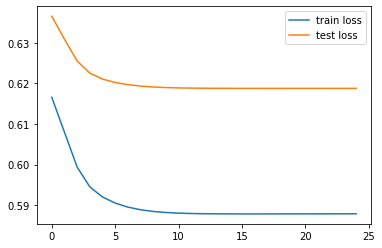

In [50]:
# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

alternative to MF vectorized 

In [51]:
# convert user2movie and movie2user to include ratings
print("converting...")
user2movierating = {}
for i, movies in user2movie.items():
  r = np.array([usermovie2rating[(i,j)] for j in movies])
  user2movierating[i] = (movies, r)
movie2userrating = {}
for j, users in movie2user.items():
  r = np.array([usermovie2rating[(i,j)] for i in users])
  movie2userrating[j] = (users, r)

# create a movie2user for test set, since we need it for loss
movie2userrating_test = {}
for (i, j), r in usermovie2rating_test.items():
  if j not in movie2userrating_test:
    movie2userrating_test[j] = [[i], [r]]
  else:
    movie2userrating_test[j][0].append(i)
    movie2userrating_test[j][1].append(r)
for j, (users, r) in movie2userrating_test.items():
  movie2userrating_test[j][1] = np.array(r)
print("conversion done")

converting...
conversion done


In [52]:
# initialize variables
K = 10 # latent dimensionality
W = np.random.randn(N, K)
b = np.zeros(N)
U = np.random.randn(M, K)
c = np.zeros(M)
mu = np.mean(list(usermovie2rating.values()))



def get_loss(m2u):
  # d: movie_id -> (user_ids, ratings)
  N = 0.
  sse = 0
  for j, (u_ids, r) in m2u.items():
    p = W[u_ids].dot(U[j]) + b[u_ids] + c[j] + mu
    delta = p - r
    sse += delta.dot(delta)
    N += len(r)
  return sse / N




epoch: 0
i: 0 N: 100
i: 10 N: 100
i: 20 N: 100
i: 30 N: 100
i: 40 N: 100
i: 50 N: 100
i: 60 N: 100
i: 70 N: 100
i: 80 N: 100
i: 90 N: 100
updated W and b: 0:00:00.081243
j: 0 M: 200
j: 20 M: 200
j: 40 M: 200
j: 60 M: 200
j: 80 M: 200
j: 100 M: 200
j: 120 M: 200
j: 140 M: 200
j: 160 M: 200
j: 180 M: 200
updated U and c: 0:00:00.156723
epoch duration: 0:00:00.243763
calculate cost: 0:00:00.028591
train loss: 0.703975694561217
test loss: 0.7342244225225154
epoch: 1
i: 0 N: 100
i: 10 N: 100
i: 20 N: 100
i: 30 N: 100
i: 40 N: 100
i: 50 N: 100
i: 60 N: 100
i: 70 N: 100
i: 80 N: 100
i: 90 N: 100
updated W and b: 0:00:00.039831
j: 0 M: 200
j: 20 M: 200
j: 40 M: 200
j: 60 M: 200
j: 80 M: 200
j: 100 M: 200
j: 120 M: 200
j: 140 M: 200
j: 160 M: 200
j: 180 M: 200
updated U and c: 0:00:00.086272
epoch duration: 0:00:00.127589
calculate cost: 0:00:00.018297
train loss: 0.6095353005949744
test loss: 0.6320859299683527
epoch: 2
i: 0 N: 100
i: 10 N: 100
i: 20 N: 100
i: 30 N: 100
i: 40 N: 100
i: 50 N: 1

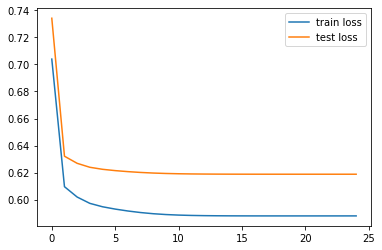

In [53]:

# train the parameters
epochs = 25
reg = 20. # regularization penalty
train_losses = []
test_losses = []
for epoch in range(epochs):
  print("epoch:", epoch)
  epoch_start = datetime.now()
  # perform updates

  # update W and b
  t0 = datetime.now()
  for i in range(N):
    m_ids, r = user2movierating[i]
    matrix = U[m_ids].T.dot(U[m_ids]) + np.eye(K) * reg
    vector = (r - b[i] - c[m_ids] - mu).dot(U[m_ids])
    bi = (r - U[m_ids].dot(W[i]) - c[m_ids] - mu).sum()

    # set the updates
    W[i] = np.linalg.solve(matrix, vector)
    b[i] = bi / (len(user2movie[i]) + reg)

    if i % (N//10) == 0:
      print("i:", i, "N:", N)
  print("updated W and b:", datetime.now() - t0)


  # update U and c
  t0 = datetime.now()
  for j in range(M):
    try:
      u_ids, r = movie2userrating[j]
      matrix = W[u_ids].T.dot(W[u_ids]) + np.eye(K) * reg
      vector = (r - b[u_ids] - c[j] - mu).dot(W[u_ids])
      cj = (r - W[u_ids].dot(U[j]) - b[u_ids] - mu).sum()

      # set the updates
      U[j] = np.linalg.solve(matrix, vector)
      c[j] = cj / (len(movie2user[j]) + reg)

      if j % (M//10) == 0:
        print("j:", j, "M:", M)
    except KeyError:
      # possible not to have any ratings for a movie
      pass
  print("updated U and c:", datetime.now() - t0)
  print("epoch duration:", datetime.now() - epoch_start)


  # store train loss
  t0 = datetime.now()
  train_losses.append(get_loss(movie2userrating))

  # store test loss
  test_losses.append(get_loss(movie2userrating_test))
  print("calculate cost:", datetime.now() - t0)
  print("train loss:", train_losses[-1])
  print("test loss:", test_losses[-1])


print("train losses:", train_losses)
print("test losses:", test_losses)

# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

Matrix Factorization in Keras 